This notebook demonstrates the use of regularization and depolarizing noise mitigation options for fidelity quantum kernels (FQKs) as described in http://arxiv.org/pdf/2105.02276v1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn.feature_map import QEKFeatureMap
from squlearn.kernel.matrix import FidelityKernel
from squlearn.kernel.ml import QKRR
from squlearn.util import Executor

In [3]:
# generate some training and test data
x = np.linspace(-0.8, 0.8, 20)
x_fine = np.linspace(-0.9, 0.9, 200)
y = np.sin(10.0 * x) * np.cos(np.exp(2 * x))

In [4]:
# define the feature map
num_qubits = 10
fmap = QEKFeatureMap(num_qubits, num_features=1, num_layers=2)

In [5]:
# initialize the feature maps variational parameters to randomly chosen values
np.random.seed(10)
parameters = np.random.rand(fmap.num_parameters)

In [10]:
# Define the executor and set the desired number of shots
executor = Executor("qasm_simulator")
executor.set_shots(1000)

##### Demonstrating regularization options in QKRR

In [8]:
# Define the FQK and assign the respective parameters
qkernel = FidelityKernel(fmap, executor=executor)
qkernel.assign_parameters(parameters)

# Set the QKRR instance and with
qkrr_inst = QKRR(
    quantum_kernel=qkernel, alpha=1e-1, regularize="thresholding"
)  # the alternative option would be 'tikhonov'
qkrr_inst.fit(x.reshape(-1, 1), y)
y_pred = qkrr_inst.predict(x_fine.reshape(-1, 1))

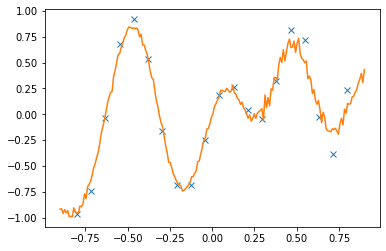

In [9]:
# Plot the results
plt.plot(x, y, "x")
plt.plot(x_fine, y_pred)

##### Demonstrating depolarizing noise mitigation for fidelity quantum kernels

In [11]:
# Set the FQK with the option of mit_depol_noise
# Since we are using only a qasm_simulator this option is in principal useless,
# however, in this case we demonstrate the availability of this option and it's main effect,
# i.e. restoring ones on the diagonal
kernel_mit = FidelityKernel(
    fmap, executor=executor, mit_depol_noise="msplit"
)  # the alternative option would be 'mmean'
kernel_mit.assign_parameters(parameters)
kernel_mit.evaluate(x.reshape(-1, 1))

array([[ 1.00000000e+00,  9.14551910e-01,  7.13235481e-01,
         4.40559009e-01,  2.20020591e-01,  7.73041177e-02,
         2.11331235e-02,  3.00633358e-03,  4.96846774e-04,
        -1.78082831e-03,  1.15588964e-03,  1.66375231e-04,
        -4.54548095e-04, -4.71210268e-05,  3.43691760e-04,
        -1.15716894e-04, -1.14456669e-04,  2.08201979e-05,
         1.77348264e-04, -1.27097159e-04],
       [ 9.14551910e-01,  1.00000000e+00,  9.09023457e-01,
         6.99876038e-01,  4.03782341e-01,  1.95499342e-01,
         5.59179619e-02,  1.84740819e-02,  2.28285258e-03,
         3.35961073e-03, -2.00646719e-03, -1.43345887e-04,
         6.88327958e-04,  3.50510139e-05, -4.88037295e-04,
         2.43984678e-04,  1.20503345e-04, -2.31384666e-05,
        -2.03800480e-04,  1.61586567e-04],
       [ 7.13235481e-01,  9.09023457e-01,  1.00000000e+00,
         8.98125188e-01,  6.51893637e-01,  3.64622998e-01,
         1.66454734e-01,  4.51242052e-02,  9.34239140e-03,
         8.09711951e-04,  2.5

In [14]:
# Compare to the kernel without this option (subtracting identiy necessary due to inherent regularization of QKRR)
print(qkrr_inst.k_train - 1e-1 * np.eye(np.shape(qkrr_inst.k_train)[0]))

[[ 1.00329637e+00  9.01392414e-01  7.23327180e-01  4.18161078e-01
   2.14472873e-01  8.50070940e-02  2.44408870e-02  1.50132901e-03
   1.61748521e-03 -1.08381453e-04  2.51658149e-04 -3.87746716e-04
   1.31444843e-04  1.02021882e-04 -4.26237241e-05 -5.01300650e-05
   2.01349326e-05  2.03437040e-05  2.18368721e-06 -1.87531344e-05]
 [ 9.01392414e-01  1.00972530e+00  9.11101133e-01  7.00554946e-01
   3.93947464e-01  1.85487511e-01  6.51801959e-02  1.80367278e-02
   5.69975197e-04 -4.67140604e-04  8.99493408e-05  3.74774175e-04
  -1.97408451e-04 -1.13729004e-04  9.75669204e-05  1.79920063e-05
  -8.72699706e-06 -3.04289453e-05 -1.77442970e-06  2.58987256e-05]
 [ 7.23327180e-01  9.11101133e-01  1.00066721e+00  9.07545894e-01
   6.74411848e-01  3.76637422e-01  1.49931056e-01  4.28410125e-02
   4.80081395e-03  1.38814229e-03 -1.12378926e-03  5.76386153e-04
  -2.36924763e-06 -1.63740493e-04 -3.57734337e-05  1.42518639e-04
  -6.42918434e-05 -2.80269172e-06 -1.91925673e-07  7.67724815e-06]
 [ 4.18